In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torchmetrics import Accuracy

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

from lisa import LISA
from itertools import chain

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cuda")

In [3]:
epochs = 100

batch_size = 128

In [4]:
normalize = transforms.Normalize(mean=[0.4563, 0.4076, 0.3895], std=[0.2298, 0.2144, 0.2259])

# lisa_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize((224, 224)),transforms.ToTensor(),normalize])
lisa_transforms = transforms.Compose([ transforms.ToPILImage(),transforms.ToTensor(),normalize])

In [10]:
%run models.ipynb
%run utils.ipynb

In [274]:
import torch

# Define the labels and their corresponding indexes
classes = ('stop', 'speedLimitUrdbl', 'speedLimit25', 'pedestrianCrossing', 'speedLimit35', 'turnLeft',
                      'slow', 'speedLimit15', 'speedLimit45', 'rightLaneMustTurn', 'signalAhead', 'keepRight',
                      'laneEnds', 'school', 'merge', 'addedLane', 'rampSpeedAdvisory40', 'rampSpeedAdvisory45',
                      'curveRight', 'speedLimit65', 'truckSpeedLimit55', 'thruMergeLeft', 'speedLimit30', 'stopAhead',
                      'yield', 'thruMergeRight', 'dip', 'schoolSpeedLimit25', 'thruTrafficMergeLeft', 'noRightTurn',
                      'rampSpeedAdvisory35', 'curveLeft', 'rampSpeedAdvisory20', 'noLeftTurn', 'zoneAhead25',
                      'zoneAhead45', 'doNotEnter', 'yieldAhead', 'roundabout', 'turnRight', 'speedLimit50',
                      'rampSpeedAdvisoryUrdbl', 'rampSpeedAdvisory50', 'speedLimit40', 'speedLimit55', 'doNotPass',
                      'intersection')

# Define the indexes for the subset
included_indexes = {0, 3, 5, 6, 10, 12, 13, 14, 24, 29, 33, 38, 39}
remapped_indexes = {2, 3, 7, 8, 19, 22, 40, 43, 44}

# Paths to the image tensors and label tensor
image_tensor_paths = [
    "datasets/lisa-batches/images_0.tensor",  # Replace with the actual path
    "datasets/lisa-batches/images_1.tensor",
    "datasets/lisa-batches/images_2.tensor"
]
label_file_path = "datasets/lisa-batches/labels.tensor"  # Replace with the actual path

# Load and concatenate all image tensors
images_tensor = torch.cat([torch.load(path) for path in image_tensor_paths], dim=0)

# Load the labels tensor
labels_tensor = torch.load(label_file_path)

# Initialize lists for the subset
subset_images = []
subset_labels = []

# Filter and process the dataset
for i, label in enumerate(labels_tensor.tolist()):
    if label in included_indexes:
        subset_images.append(images_tensor[i])
        subset_labels.append(label)  # Keep the original label
    elif label in remapped_indexes:
        subset_images.append(images_tensor[i])
        subset_labels.append(50)  # Remap the label to "speedlimit"


# Convert the subset to tensors
subset_images_tensor = torch.stack(subset_images)
subset_labels_tensor = torch.tensor(subset_labels)

# Save the new subset tensors
torch.save(subset_images_tensor, "datasets/lisa-batches/subset_images.tensor")  # Replace with the desired save path
torch.save(subset_labels_tensor, "datasets/lisa-batches/subset_labels.tensor")  # Replace with the desired save path

print("Subset creation complete!")


Subset creation complete!


In [285]:
import torch

# Path to the original label tensor file
label_tensor_path = "datasets/lisa-batches/subset_labels.tensor"  # Replace with the actual path

# Load the label tensor
labels_tensor = torch.load(label_tensor_path)

# Define the mapping of original labels to new labels
label_mapping = {
    0: 0,  # Old 0 -> New 0
    50: 1, # Old 50 -> New 1
    3: 2,  # Old 3 -> New 2
    5: 3,  # Old 5 -> New 3
    6: 4,  # Old 6 -> New 4
    10: 5, # Old 10 -> New 5
    12: 6, # Old 12 -> New 6
    13: 7, # Old 13 -> New 7
    14: 8, # Old 14 -> New 8
    24: 9, # Old 24 -> New 9
    29: 10, # Old 29 -> New 10
    33: 11, # Old 33 -> New 11
    38: 12, # Old 38 -> New 12
    39: 13  # Old 39 -> New 14
}

# Apply the label mapping to the tensor
remapped_labels = torch.tensor([label_mapping[label.item()] if label.item() in label_mapping else -1 for label in labels_tensor])

# Save the remapped labels tensor to a file
save_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with your desired save path
torch.save(remapped_labels, save_path)

print(f"Remapped labels saved to: {save_path}")


Remapped labels saved to: datasets/lisa-batches/subset_labels2.tensor


In [12]:
from collections import Counter
label_file_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with the actual path

# Load the labels tensor
labels_tensor = torch.load(label_file_path)

# Convert the tensor to a list for easy inspection
labels_list = labels_tensor.tolist()

label_counts = Counter(labels_list)

# Print the unique labels and their counts
print("Number of images in each label:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

# Optional: Print the total number of images
print(f"Total number of images: {sum(label_counts.values())}")

Number of images in each label:
Label 0: 1821 images
Label 1: 838 images
Label 2: 1085 images
Label 3: 32 images
Label 4: 34 images
Label 5: 925 images
Label 6: 210 images
Label 7: 133 images
Label 8: 266 images
Label 9: 236 images
Label 10: 26 images
Label 11: 47 images
Label 12: 53 images
Label 13: 92 images
Total number of images: 5798


In [9]:
classes = ['stop','speedlimit', 'pedestrianCrossing', 'turnLeft','slow', 'signalAhead', 'laneEnds', 'school', 'merge','yield', 'noRightTurn','noLeftTurn', 'roundabout', 'turnRight']
import torch
from torch.utils.data import Dataset

class SubsetLISA(Dataset):
    """
    A custom dataset for the LISA subset, created using filtered image and label tensors.
    """
    def __init__(self, image_tensor_path, label_tensor_path,train:bool, transform=None):
        """
        Args:
            image_tensor_path (str): Path to the images tensor file.
            label_tensor_path (str): Path to the labels tensor file.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.images = torch.load(image_tensor_path)
        self.labels = torch.load(label_tensor_path)
        self.transform = transform
        self.train = train
        self._train_test_split()

        assert len(self.images) == len(self.labels), "Images and labels length mismatch"

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is the input tensor and label is the target tensor.
        """
        image = self.images[index]
        target = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, target

    def _train_test_split(self, test_percent: float = 0.16):
        classes = {}
        for i, cl in enumerate(self.labels.numpy()):
            arr = classes.get(cl, [])
            arr.append(i)
            classes[cl] = arr

        train, test = [], []
        for cl, arr in classes.items():
            split_index = int(len(arr) * test_percent)
            test = test + arr[:split_index]
            train = train + arr[split_index:]

        sub = train if self.train else test
        self.images, self.labels = self.images[sub], self.labels[sub]


In [21]:
# Paths to the saved subset tensors
image_tensor_path = "datasets/lisa-batches/subset_images.tensor"  # Replace with your actual file path
label_tensor_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with your actual file path

# Initialize the dataset
train_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=True, transform = lisa_transforms)
test_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=False, transform = lisa_transforms)

print(len(train_dataset))
print(len(test_dataset))



4876
922


(32, 32, 3)


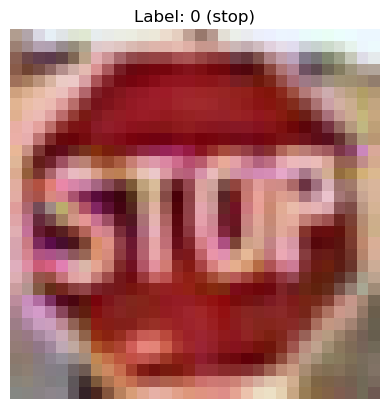

In [23]:
# Get a sample 4796 and label
sample_index = 800

# Change index to see different samples
image, label = train_dataset[sample_index]

# Convert the image tensor to a format suitable for display
image = image.permute(1, 2, 0).numpy()
print(image.shape)# Convert (C, H, W) to (H, W, C)
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

# Visualize the image
plt.imshow(image)
plt.title(f"Label: {label} ({classes[label]})")  # Display the label
plt.axis('off')
plt.show()